<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/053.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

In [55]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [56]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test.csv', index_col=0)

In [57]:
train_df

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,MIDLOTHIAN COMPRESSOR STATION,32.523334,-97.102556,2624 CHAMBERS ST.,VENUS,TX,76084,JOHNSON,48251.0,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06
4651,PARADISE COMPRESSOR STATION,42.684900,-109.780000,"SECTION 2, T31N, R109W",PINEDALE,WY,82941,SUBLETTE,56035.0,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04
4652,UNIV OF OK HEALTH S/OKC CAMPUS SVCS,35.484260,-97.498570,800 NE 15TH ST,OKLAHOMA CITY,OK,73104,OKLAHOMA,40109.0,611310,NaN,Other,NaN,NaN,NaN,NaN,563756.090695,598881.479485,1.665103e+06,543206.073134,9.783592e+05
4653,HARFORD CO. RESOURCE RECOVERY FACILITY,39.404310,-76.319820,1 MAGNOLIA ROAD,JOPPA,MD,21085-4800,HARFORD,24025.0,562213,NaN,Waste,NaN,NaN,NaN,NaN,67451.225733,27397.929966,3.922795e+04,46634.777768,2.723434e+04


In [58]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

In [59]:
train_df["GHG_Direct_Emissions_14_in_metric_tons"] = np.log1p(train_df["GHG_Direct_Emissions_14_in_metric_tons"])
train_df["GHG_Direct_Emissions_13_in_metric_tons"] = np.log1p(train_df["GHG_Direct_Emissions_13_in_metric_tons"])
train_df["GHG_Direct_Emissions_12_in_metric_tons"] = np.log1p(train_df["GHG_Direct_Emissions_12_in_metric_tons"])
train_df["GHG_Direct_Emissions_11_in_metric_tons"] = np.log1p(train_df["GHG_Direct_Emissions_11_in_metric_tons"])
train_df["GHG_Direct_Emissions_10_in_metric_tons"] = np.log1p(train_df["GHG_Direct_Emissions_10_in_metric_tons"])
train_df["TRI_Air_Emissions_13_in_lbs"] = np.log1p(train_df["TRI_Air_Emissions_13_in_lbs"])
train_df["TRI_Air_Emissions_12_in_lbs"] = np.log1p(train_df["TRI_Air_Emissions_12_in_lbs"])
train_df["TRI_Air_Emissions_11_in_lbs"] = np.log1p(train_df["TRI_Air_Emissions_11_in_lbs"])
train_df["TRI_Air_Emissions_10_in_lbs"] = np.log1p(train_df["TRI_Air_Emissions_10_in_lbs"])


In [60]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [61]:
# del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

In [62]:

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [63]:
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics']

econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [64]:
test_df.shape

(2508, 16)

In [65]:



def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (mean radius)
    R = 6371.0

    # Calculate the distance
    distance = R * c
    return distance

In [66]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # Extract the required columns once to NumPy arrays
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # Filter NaN emissions directly
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # Parallelize distance calculation using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # Combine the results into a DataFrame
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        # Sort distances by 'Distance'
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # Filter by economic sector
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # Get the top N nearest for both economic sector and overall
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # Compute weighted averages
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # Compute regular averages
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [67]:
# neighbours = 5

# # テストデータの距離計算または読み込み
# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     test_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):
#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=False)
#         output.append(x)

#     test_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     test_distance.to_csv(file_path, index=False)

# # トレーニングデータの距離計算または読み込み
# file_path = f"train_distance_{neighbours}nbrs.csv"  # f-string を正しく使用
# if os.path.exists(file_path):
#     print(f"{file_path} exists.")
#     train_distance = pd.read_csv(file_path)
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['Economic_Sector']
#         x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=True)
#         output.append(x)

#     train_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average', 'Nearest_Weighted_Average', 'Nearest_Average'])
#     train_distance.to_csv(file_path, index=False)

train_distance = pd.read_csv(path+"train_distance_5nbrs.csv")
test_distance  = pd.read_csv(path+"test_distance_5nbrs.csv")

In [68]:
test_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Economic_Sector
0,38.033040,-97.973170,HUTCHINSON,KS,RENO,20155.0,211112,NaN,NaN,NaN,NaN,88951.390376,65803.021457,2.899329e+04,32965.487915,"Mining, Quarrying, and Oil and Gas Extraction"
1,32.316030,-108.606800,LORDSBURG,NM,HIDALGO,35023.0,486210,NaN,NaN,NaN,NaN,NaN,NaN,3.119260e+05,268668.069110,Transportation and Warehousing
2,41.251500,-78.742440,BROCKPORT,PA,JEFFERSON,42065.0,327213,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387,Manufacturing
3,44.959660,-93.193410,SAINT PAUL,MN,RAMSEY,27123.0,322130,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986,Manufacturing
4,32.818720,-117.125800,SAN DIEGO,CA,SAN DIEGO,6073.0,333611,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,38.651945,-75.914445,HURLOCK,MD,DORCHESTER,24019.0,562212,NaN,NaN,NaN,NaN,110523.066755,98954.793233,3.467008e+06,147802.356027,Administrative and Support and Waste Managemen...
2504,31.361795,-101.776403,RANKIN,TX,UPTON,48461.0,211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mining, Quarrying, and Oil and Gas Extraction"
2505,41.005565,-96.154917,LOUISVILLE,NE,CASS,31025.0,327310,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307153,Manufacturing
2506,39.364417,-93.449361,CARROLLTON,MO,CARROLL,29033.0,325193,124460.895022,140816.449347,93118.705227,130326.946431,71773.803649,936031.894142,3.369613e+05,156640.371706,Manufacturing


In [69]:
test_distance

,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average
0,28019.568906,369614.866259,454847.563793,606222.120889
1,1296.575343,75372.922188,26392.933789,299096.231937
2,59857.420688,44340.597367,81533.914173,203831.976280
3,45265.635701,127292.222361,297072.418525,405635.394345
4,8838.742950,70847.235694,617665.034364,290001.288780
...,...,...,...,...
2503,46677.018970,344616.752313,45282.942220,309317.094507
2504,290186.877822,544751.143291,290186.877822,544751.143291
2505,102525.917615,658668.333532,100759.314574,598531.117832
2506,3259.275220,58047.779667,8262.408868,91773.030660


In [70]:
train_df.shape

(4655, 17)

In [71]:
train_df = pd.concat([train_df, train_distance], axis=1)
test_df = pd.concat([test_df, test_distance], axis=1)


In [72]:
def create_features1(df):


    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # Year-over-year growth rate with NaN protection
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [73]:
def create_features2(df):


    # Year-over-year difference
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # Year-over-year growth rate for GHG Direct Emissions with NaN protection
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [74]:
def create_features3(df):
    df['TRI_to_GHG_Ratio_10'] = np.where(df['GHG_Direct_Emissions_10_in_metric_tons'].notna(),
                                     df['TRI_Air_Emissions_10_in_lbs'] / df['GHG_Direct_Emissions_10_in_metric_tons'],
                                     np.nan)

    df['TRI_to_GHG_Ratio_11'] = np.where(df['GHG_Direct_Emissions_11_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_11_in_lbs'] / df['GHG_Direct_Emissions_11_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_12'] = np.where(df['GHG_Direct_Emissions_12_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_12_in_lbs'] / df['GHG_Direct_Emissions_12_in_metric_tons'],
                                        np.nan)

    df['TRI_to_GHG_Ratio_13'] = np.where(df['GHG_Direct_Emissions_13_in_metric_tons'].notna(),
                                        df['TRI_Air_Emissions_13_in_lbs'] / df['GHG_Direct_Emissions_13_in_metric_tons'],
                                        np.nan)
    return df



train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

In [75]:
summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min','count']})

summary_df.columns = [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]

summary_df = summary_df.reset_index()

train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
test_df  = test_df.merge(summary_df,  on=['Economic_Sector', 'State'], how='left')

In [76]:
test_df.shape

(2508, 41)

In [77]:
train_df.shape

(4655, 42)

In [78]:
merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 42), (2508, 42))

In [79]:
train_df["num_missing"] = train_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
test_df["num_missing"] = test_df.iloc[:, 5:9].isna().any(axis=1).astype(int)
train_df["num_missing"]

,num_missing
0,0
1,1
2,1
3,1
4,0
...,...
4650,1
4651,1
4652,1
4653,1


In [80]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing
0,40.141389,-87.581111,760,15,1210,404,118,10.359890,10.190394,10.060978,10.367563,11.079338,10.507523,10.542942,10.727644,10.877559,8,5398.155496,47189.689731,9791.821519,33589.247020,-0.169496,-0.129416,0.306585,-0.016361,-0.012700,0.030473,-0.571815,0.035419,0.184702,-0.051611,0.003371,0.017519,0.935064,0.969819,0.954286,0.966434,11.117083,10.972440,14.951745,8.478544,65.0,0
1,38.475305,-81.278957,596,52,580,1812,221,NaN,NaN,NaN,NaN,10.924292,11.189800,10.972091,11.243444,10.931518,14,162817.726845,400092.854554,148763.385132,132464.910913,NaN,NaN,NaN,NaN,NaN,NaN,0.265508,-0.217710,0.271353,0.024304,-0.019456,0.024731,NaN,NaN,NaN,NaN,11.932794,12.041200,13.403792,10.555769,10.0,1
2,39.299820,-80.857170,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.927386,9,103977.856885,417284.756655,218812.028673,483238.414520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.200733,11.059499,14.227386,9.268422,44.0,1
3,35.490363,-119.042957,158,4,597,118,21,NaN,NaN,NaN,NaN,10.911668,11.146791,11.061129,10.893029,11.025375,15,131970.843732,103867.454791,131970.843732,103867.454791,NaN,NaN,NaN,NaN,NaN,NaN,0.235122,-0.085662,-0.168100,0.021548,-0.007685,-0.015197,NaN,NaN,NaN,NaN,11.470227,11.121024,14.726550,8.338143,98.0,1
4,41.532802,-81.636448,598,36,289,1206,21,10.294001,10.251988,10.336627,10.132808,11.312195,10.893485,11.256641,9.779282,10.671312,15,13380.967037,32692.160052,59477.156966,94820.654861,-0.042013,0.084639,-0.203819,-0.004081,0.008256,-0.019718,-0.418710,0.363156,-1.477359,-0.037014,0.033337,-0.131243,0.909991,0.941112,0.918269,1.036151,11.059918,10.728805,14.569943,9.468105,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,3123,45,570,1588,3,NaN,NaN,NaN,NaN,10.914722,10.941372,15.074763,11.246922,14.712088,9,180502.129556,330574.656900,116105.385412,145931.879241,NaN,NaN,NaN,NaN,NaN,NaN,0.026650,4.133391,-3.827841,0.002442,0.377776,-0.253924,NaN,NaN,NaN,NaN,11.453147,11.102835,15.045927,8.099651,184.0,1
4651,42.684900,-109.780000,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,12.247102,10.951992,10.790994,10.199635,10.484047,9,54997.983919,348657.682514,54997.983919,348657.682514,NaN,NaN,NaN,NaN,NaN,NaN,-1.295109,-0.160998,-0.591359,-0.105748,-0.014700,-0.054801,NaN,NaN,NaN,NaN,11.456313,11.123950,14.911101,9.591241,44.0,1
4652,35.484260,-97.498570,2231,37,842,1301,244,NaN,NaN,NaN,NaN,13.242379,13.302821,14.325398,13.205246,13.793633,5,671.590561,62159.523104,36606.859261,103844.423289,NaN,NaN,NaN,NaN,NaN,NaN,0.060442,1.022578,-1.120152,0.004564,0.076869,-0.078193,NaN,NaN,NaN,NaN,13.793633,13.793633,13.793633,13.793633,1.0,1
4653,39.404310,-76.319820,1533,21,486,718,241,NaN,NaN,

In [81]:
numerical_columns = [
                    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                    ]
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']
train_aggregations  =  [
                        'GHG_Direct_Emissions_14_in_metric_tons_mean',
                        'GHG_Direct_Emissions_14_in_metric_tons_median',
                        'GHG_Direct_Emissions_14_in_metric_tons_max',
                        'GHG_Direct_Emissions_14_in_metric_tons_min',
                        'GHG_Direct_Emissions_14_in_metric_tons_count'
                     ]
new_features1  = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                    'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

new_features2   = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                  'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                  ]
new_features3   = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']
neighbour_feats = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average']


train = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]
                 ].values
test  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                 ].values
target = train_df[target_columns].values


In [82]:
test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
        +["num_missing"]
                 ]


,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0


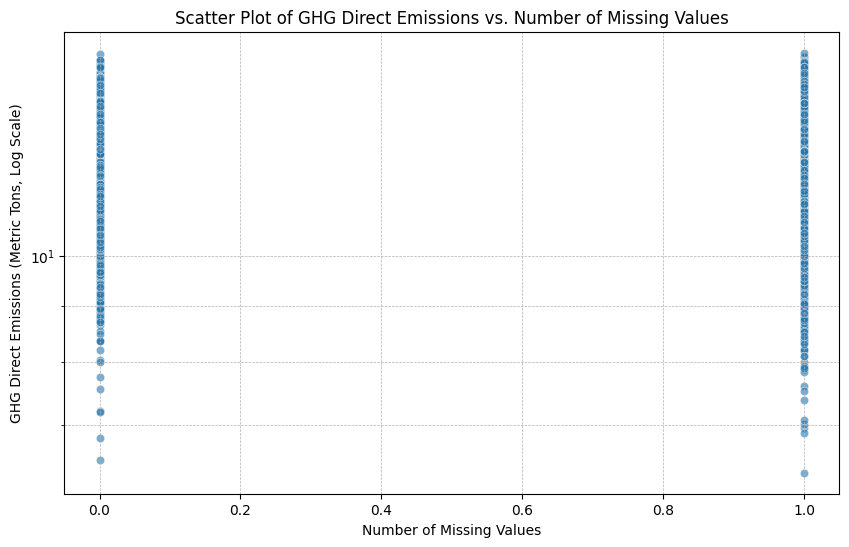

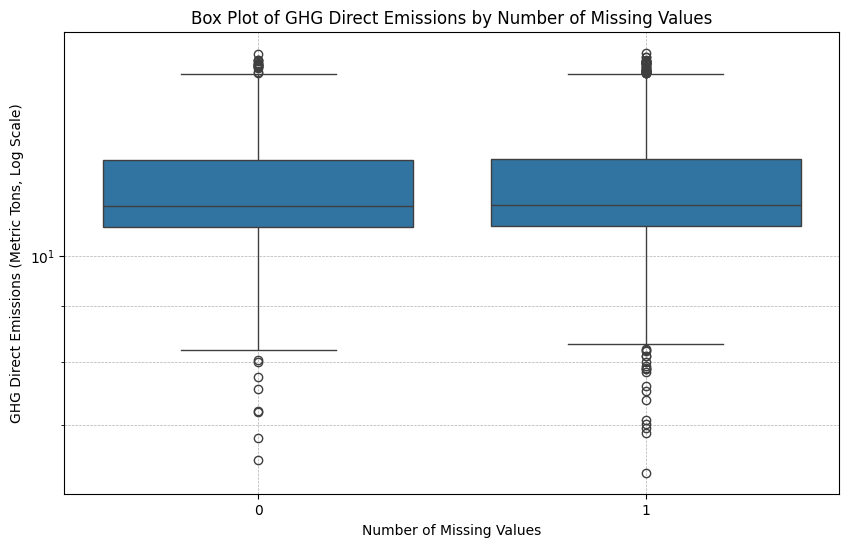

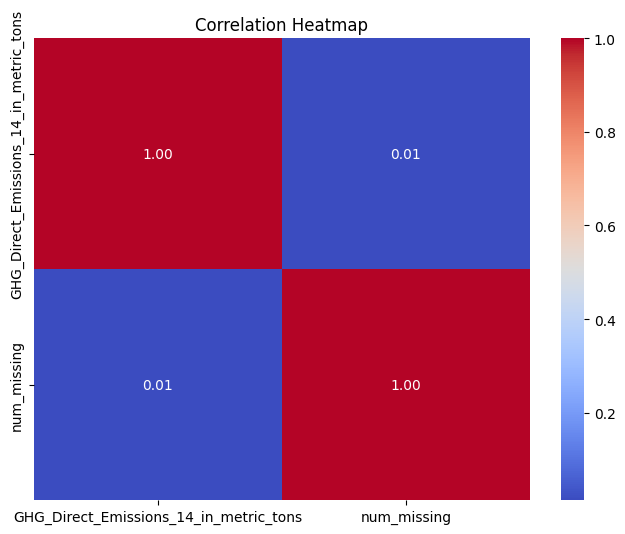

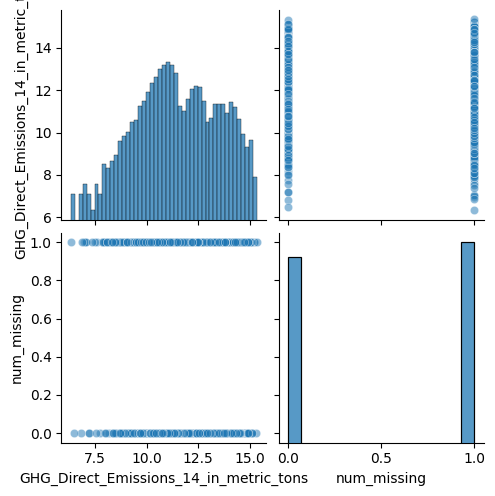

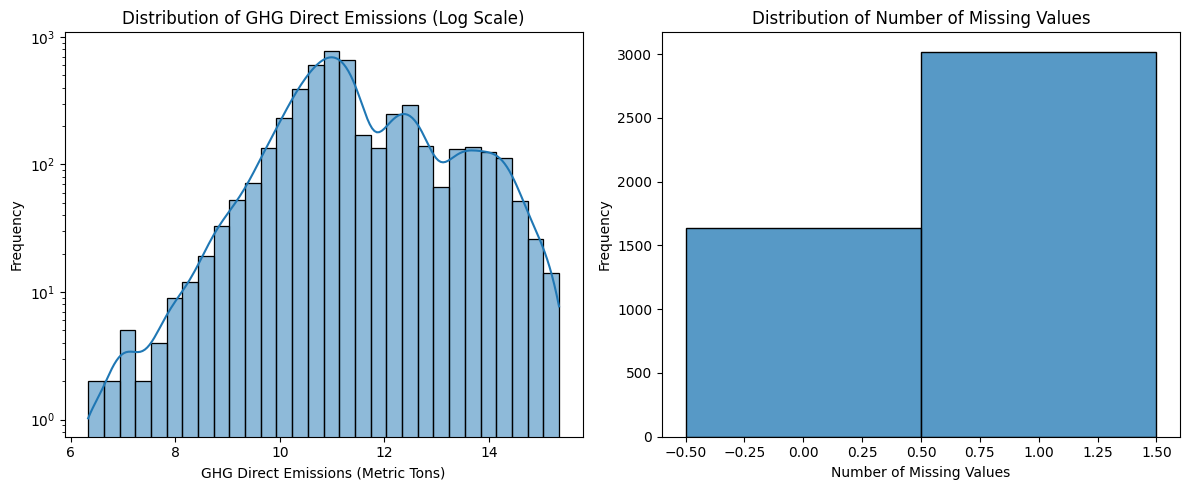

In [83]:

import seaborn as sns
filtered_train_df = train_df[train_df["GHG_Direct_Emissions_14_in_metric_tons"] > 0]
# 1. 散布図（Scatter Plot）
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons",
    alpha=0.6
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Scatter Plot of GHG Direct Emissions vs. Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 2. 箱ひげ図（Box Plot）
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_train_df,
    x="num_missing",
    y="GHG_Direct_Emissions_14_in_metric_tons"
)
plt.yscale('log')  # Y軸を対数スケールに設定
plt.title("Box Plot of GHG Direct Emissions by Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("GHG Direct Emissions (Metric Tons, Log Scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

# 3. ヒートマップ（Heatmap） - 相関行列の可視化
plt.figure(figsize=(8, 6))
correlation = filtered_train_df[["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4. ペアプロット（Pair Plot） - 複数の視点からの可視化
sns.pairplot(filtered_train_df, vars=["GHG_Direct_Emissions_14_in_metric_tons", "num_missing"],
             kind='scatter', plot_kws={'alpha':0.5})
plt.yscale('log')
plt.show()

# 5. ヒストグラム（Histogram） - 各変数の分布
plt.figure(figsize=(12, 5))

# GHG_Direct_Emissions_14_in_metric_tons のヒストグラム（対数スケール）
plt.subplot(1, 2, 1)
sns.histplot(filtered_train_df["GHG_Direct_Emissions_14_in_metric_tons"], bins=30, kde=True)
plt.yscale('log')
plt.title("Distribution of GHG Direct Emissions (Log Scale)")
plt.xlabel("GHG Direct Emissions (Metric Tons)")
plt.ylabel("Frequency")

# num_missing のヒストグラム
plt.subplot(1, 2, 2)
sns.histplot(filtered_train_df["num_missing"], bins=range(filtered_train_df["num_missing"].max()+2), discrete=True, kde=False)
plt.title("Distribution of Number of Missing Values")
plt.xlabel("Number of Missing Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [84]:
train_df["less_10^4"] = train_df["GHG_Direct_Emissions_14_in_metric_tons"].apply(lambda x: 1 if x < 10**4 else 0)
target_less_10_4 = train_df["less_10^4"].values



In [85]:
target

array([[10.87755915],
       [10.93151761],
       [10.92738605],
       ...,
       [13.79363317],
       [10.21227072],
       [12.1798471 ]])

In [87]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


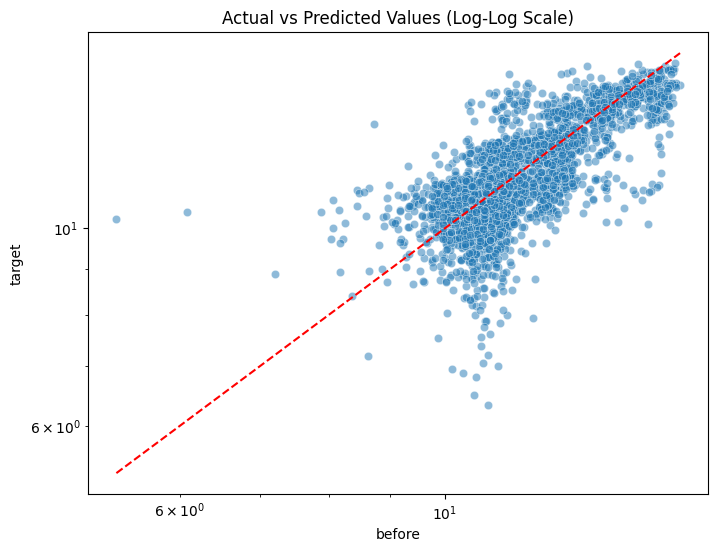

In [88]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

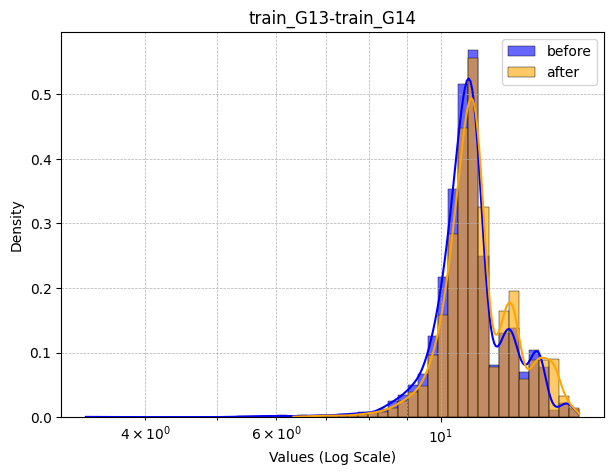

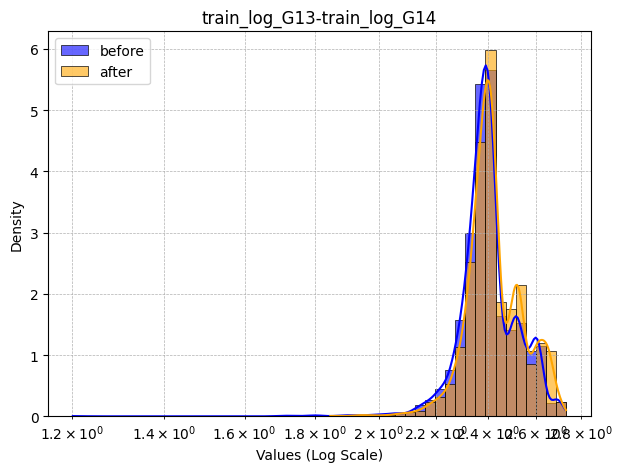

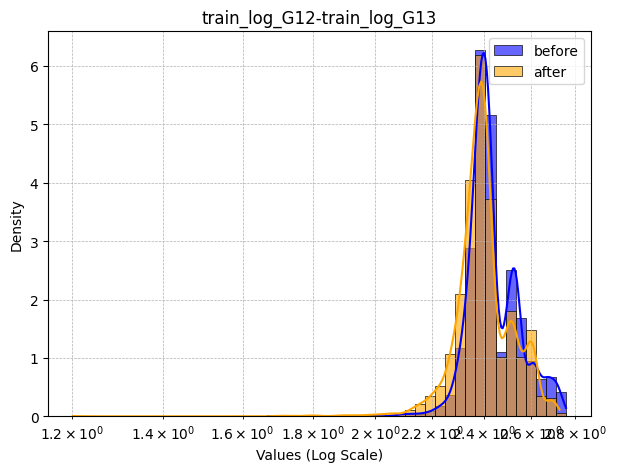

In [89]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [96]:
from itertools import combinations


def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0
    print("Initial combination counts:", combination_count)

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor（コメントに合わせて修正）
        params                       = {'n_estimators': 272,
                                        'learning_rate': 0.015429026765686638,
                                        'max_depth': 5,
                                        'num_leaves': 22,
                                        'feature_fraction': 0.7098433341459348,
                                        'bagging_fraction': 0.8672618516682183,
                                        'min_data_in_leaf': 93,
                                        'lambda_l1': 0.6694340926741666,
                                        'lambda_l2': 0.34745125970141677,
                                         "verbose":-1,}
        model2                       = LGBMRegressor(**params, verbosity=-1)

        # モデル3: XGBRegressor
        params3 = {
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            'iterations': 995,
            'depth': 5,
            'learning_rate': 0.05468530182759963,
            'l2_leaf_reg': 1,
            'bagging_temperature': 0.8485521654871782,
            'min_data_in_leaf': 19,
            'random_state': 13
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)  # 必要に応じて y_train を変換
            preds = model.predict(X_valid)
            # RMSLEを計算する際、y_valid と preds が正であることを確認
            # 必要に応じて np.log1p と np.expm1 を使用
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")

        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple) and len(best_combination) > 1:
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            print(f"Fold {fold + 1} selected combination: {best_combination}")
        else:
            # 単一モデル
            single_model = best_combination if isinstance(best_combination, str) else best_combination[0]
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[single_model].predict(test)
            print(f"Fold {fold + 1} selected single model: {single_model}")

        test_predictions += test_preds / kf.n_splits

        # 各組み合わせの選択回数をインクリメント
        if not isinstance(best_combination, tuple) or (isinstance(best_combination, tuple) and len(best_combination) == 1):
            best_combination = (best_combination,) if isinstance(best_combination, str) else best_combination
        combination_count[best_combination] += 1

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"Final OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換（必要に応じて）
    final_test_predictions = test_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    print("\nNumber of times each combination was selected:")
    for comb, count in combination_count.items():
        print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions

In [98]:
oof_predictions,test_preds = get_models_trained(train,test,target,30)

Initial combination counts: {('model1',): 0, ('model2',): 0, ('model3',): 0, ('model4',): 0, ('model1', 'model2'): 0, ('model1', 'model3'): 0, ('model1', 'model4'): 0, ('model2', 'model3'): 0, ('model2', 'model4'): 0, ('model3', 'model4'): 0, ('model1', 'model2', 'model3'): 0, ('model1', 'model2', 'model4'): 0, ('model1', 'model3', 'model4'): 0, ('model2', 'model3', 'model4'): 0, ('model1', 'model2', 'model3', 'model4'): 0}
Starting Fold 1
Fold 1 RMSLE for model1 = 0.05535090796887038
Fold 1 RMSLE for model2 = 0.055477982755065866
Fold 1 RMSLE for model3 = 0.05514435946330511
Fold 1 RMSLE for model4 = 0.058761149492225856
Fold 1 RMSLE for ('model1', 'model2') = 0.05532098480935802
Fold 1 RMSLE for ('model1', 'model3') = 0.05522519750785765
Fold 1 RMSLE for ('model1', 'model4') = 0.0566550832844756
Fold 1 RMSLE for ('model2', 'model3') = 0.055244293900042
Fold 1 RMSLE for ('model2', 'model4') = 0.05668099967123309
Fold 1 RMSLE for ('model3', 'model4') = 0.05660079394198991
Fold 1 RMSLE 

In [99]:
train_tmp_df = train_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                 +["num_missing"]+
                  ["GHG_Direct_Emissions_14_in_metric_tons"]
                 ]
test_tmp_df  = test_df[numerical_columns+
                 lat_lon_columns+
                #  categorical_columns+
                 new_features1+['Economic_Sector']
                #  new_features2
               #   new_features3+
                #  train_aggregations+
               #   neighbour_feats
                +["num_missing"]
                   ]
target = train_df[target_columns]
oof_predictions_pd = pd.DataFrame(oof_predictions, columns=["oof_predictions"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
test_preds_pd = pd.DataFrame(test_preds, columns=["test_preds"])
train_df_1 = pd.concat([train_tmp_df, oof_predictions_pd], axis=1)
train_all_df = pd.concat([train_df_1, target], axis=1)
test_all_df = pd.concat([test_tmp_df, test_preds_pd], axis=1)

In [100]:
test_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,test_preds
0,NaN,NaN,NaN,NaN,4,88951.390376,65803.021457,2.899329e+04,32965.487915,38.033040,-97.973170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,14.510366
1,NaN,NaN,NaN,NaN,221,NaN,NaN,3.119260e+05,268668.069110,32.316030,-108.606800,NaN,NaN,NaN,NaN,NaN,NaN,14,1,14.099256
2,28275.061385,32075.140635,26445.792090,23385.161510,130,84908.372871,6212.899604,3.473291e+04,39045.247387,41.251500,-78.742440,3800.079250,-5629.348545,-3060.630580,0.134397,-0.175505,-0.115732,8,0,14.130644
3,37330.205714,42503.897432,43906.102080,42958.306538,82,49004.603631,52.038452,1.426237e+04,20204.924986,44.959660,-93.193410,5173.691718,1402.204648,-947.795542,0.138593,0.032990,-0.021587,8,0,14.281407
4,45310.722699,39897.800897,40203.428231,39437.099224,181,84959.769922,15351.359676,4.000654e+04,63935.249120,32.818720,-117.125800,-5412.921803,305.627335,-766.329007,-0.119462,0.007660,-0.019061,8,0,14.425102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,14.579117
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,11.613731
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,14.262060
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,14.007687


In [101]:
train_df

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,Economic_Sector,Economy_Sector_Weighted_Avg,Economic_Sector_Average,Nearest_Weighted_Average,Nearest_Average,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,GHG_Direct_Emissions_YoY_Change_11,GHG_Direct_Emissions_YoY_Change_12,GHG_Direct_Emissions_YoY_Change_13,GHG_Direct_Emissions_Growth_Rate_11,GHG_Direct_Emissions_Growth_Rate_12,GHG_Direct_Emissions_Growth_Rate_13,TRI_to_GHG_Ratio_10,TRI_to_GHG_Ratio_11,TRI_to_GHG_Ratio_12,TRI_to_GHG_Ratio_13,GHG_Direct_Emissions_14_in_metric_tons_mean,GHG_Direct_Emissions_14_in_metric_tons_median,GHG_Direct_Emissions_14_in_metric_tons_max,GHG_Direct_Emissions_14_in_metric_tons_min,GHG_Direct_Emissions_14_in_metric_tons_count,num_missing,less_10^4
0,40.141389,-87.581111,760,15,1210,404,118,10.359890,10.190394,10.060978,10.367563,11.079338,10.507523,10.542942,10.727644,10.877559,8,5398.155496,47189.689731,9791.821519,33589.247020,-0.169496,-0.129416,0.306585,-0.016361,-0.012700,0.030473,-0.571815,0.035419,0.184702,-0.051611,0.003371,0.017519,0.935064,0.969819,0.954286,0.966434,11.117083,10.972440,14.951745,8.478544,65.0,0,1
1,38.475305,-81.278957,596,52,580,1812,221,NaN,NaN,NaN,NaN,10.924292,11.189800,10.972091,11.243444,10.931518,14,162817.726845,400092.854554,148763.385132,132464.910913,NaN,NaN,NaN,NaN,NaN,NaN,0.265508,-0.217710,0.271353,0.024304,-0.019456,0.024731,NaN,NaN,NaN,NaN,11.932794,12.041200,13.403792,10.555769,10.0,1,1
2,39.299820,-80.857170,1267,52,971,1831,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.927386,9,103977.856885,417284.756655,218812.028673,483238.414520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.200733,11.059499,14.227386,9.268422,44.0,1,1
3,35.490363,-119.042957,158,4,597,118,21,NaN,NaN,NaN,NaN,10.911668,11.146791,11.061129,10.893029,11.025375,15,131970.843732,103867.454791,131970.843732,103867.454791,NaN,NaN,NaN,NaN,NaN,NaN,0.235122,-0.085662,-0.168100,0.021548,-0.007685,-0.015197,NaN,NaN,NaN,NaN,11.470227,11.121024,14.726550,8.338143,98.0,1,1
4,41.532802,-81.636448,598,36,289,1206,21,10.294001,10.251988,10.336627,10.132808,11.312195,10.893485,11.256641,9.779282,10.671312,15,13380.967037,32692.160052,59477.156966,94820.654861,-0.042013,0.084639,-0.203819,-0.004081,0.008256,-0.019718,-0.418710,0.363156,-1.477359,-0.037014,0.033337,-0.131243,0.909991,0.941112,0.918269,1.036151,11.059918,10.728805,14.569943,9.468105,26.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,3123,45,570,1588,3,NaN,NaN,NaN,NaN,10.914722,10.941372,15.074763,11.246922,14.712088,9,180502.129556,330574.656900,116105.385412,145931.879241,NaN,NaN,NaN,NaN,NaN,NaN,0.026650,4.133391,-3.827841,0.002442,0.377776,-0.253924,NaN,NaN,NaN,NaN,11.453147,11.102835,15.045927,8.099651,184.0,1,1
4651,42.684900,-109.780000,2382,53,1135,1898,3,NaN,NaN,NaN,NaN,12.247102,10.951992,10.790994,10.199635,10.484047,9,54997.983919,348657.682514,54997.983919,348657.682514,NaN,NaN,NaN,NaN,NaN,NaN,-1.295109,-0.160998,-0.591359,-0.105748,-0.014700,-0.054801,NaN,NaN,NaN,NaN,11.456313,11.123950,14.911101,9.591241,44.0,1,1
4652,35.484260,-97.498570,2231,37,842,1301,244,NaN,NaN,NaN,NaN,13.242379,13.302821,14.325398,13.205246,13.793633,5,671.590561,62159.523104,36606.859261,103844.423289,NaN,NaN,NaN,NaN,NaN,NaN,0.060442,1.022578,-1.120152,0.004564,0.076869,-0.078193,NaN,NaN,NaN,NaN,13.793633,13.793633,13.793633,13.793633,1.0,1,1
4653,39.404310,-76.31982

In [102]:
train_all_df.to_csv("train_all_df_053.csv", index=False)
test_all_df.to_csv("test_all_df_053.csv", index=False)